In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import wcs
import scipy.constants as c
from matplotlib import style
import scipy.stats as stats
import emcee
import corner
import astropy.units as u
from matplotlib import cm
from matplotlib.colors import ListedColormap
palette = cm.get_cmap("tab20", 20)

plt.style.use(['science', 'no-latex'])


In [3]:
#here we open the fits files
pol_I_hdu = fits.open('Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits')[0]
pol_Q_hdu = fits.open('Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits')[0]
pol_U_hdu = fits.open('Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits')[0]

#here we open the headers
I_header = pol_I_hdu.header
Q_header = pol_Q_hdu.header
U_header = pol_U_hdu.header

#here we import the data
I_data = pol_I_hdu.data[0]
Q_data = pol_Q_hdu.data[0]
U_data = pol_U_hdu.data[0]

#here we calculate the mean over all frequencies
I_freqmean = np.nanmean(I_data, axis=0)
Q_freqmean = np.nanmean(Q_data, axis=0)
U_freqmean = np.nanmean(U_data, axis=0)

print(I_header, Q_header)

#Here we define the subband frequencies, we have 12 bands, all of which have have a higher, lower and middle frequency
freq_l = np.zeros(12)
freq_m = np.zeros(12)
freq_h = np.zeros(12)

#now we fill the lists with teh frequencies from the header

for n in range(12):
    number = str((4-len(str(n+1)))*'0'+str(n+1))
    freq_l[n] = I_header['FREL'+number]
    freq_m[n] = I_header['FREQ'+number]
    freq_h[n] = I_header['FREH'+number]

#Define teh world coordinate system    
I_wcs = WCS(I_header)
Q_wcs = WCS(Q_header)
U_wcs = WCS(U_header)

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    4 / number of data axes                            NAXIS1  =                 3617 / length of data axis 1                          NAXIS2  =                 3617 / length of data axis 2                          NAXIS3  =                   12 / length of data axis 3                          NAXIS4  =                    1 / length of data axis 4                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CTYPE1  = 'RA---SIN'           / Axis type                                      CDELT1  =        -3.317774E-04 / Axis coordinate increment                      CRPIX1  =         1.809000E+03 / Axis co

In [4]:
lin_pol = np.sqrt(Q_data**2+U_data**2)
lin_pol_freqmean = np.nanmean(lin_pol, axis=0)
linpol_hdu = fits.PrimaryHDU(lin_pol)
linpol_hdu.writeto(r'\Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

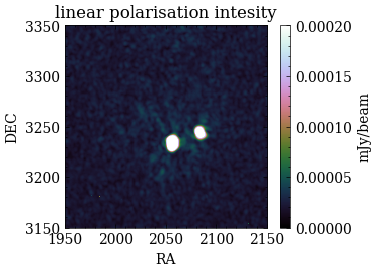

In [5]:
plt.figure()
# plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
map1 = plt.imshow(lin_pol_freqmean, cmap='cubehelix',vmin=0, vmax=0.0002, interpolation='nearest')
plt.colorbar(map1, label = 'mJy/beam')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.xlim(1950,2150)
plt.ylim(3150,3350)

# apertures.plot(color='white')
# annulus.plot(color='white')
plt.title(r'linear polarisation intesity')
plt.show()


In [6]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus

mean, median, std = sigma_clipped_stats(lin_pol_freqmean, sigma=3.0)  
print((mean, median, std))

#for i in range(12):
# meanI, medianI, stdI = sigma_clipped_stats(I_freqmean, sigma=3.0)  
# print((meanI, medianI, stdI))

# meanU, medianU, stdU = sigma_clipped_stats(U_freqmean, sigma=3.0)  
# print((meanU, medianU, stdU))

# meanQ, medianQ, stdQ = sigma_clipped_stats(Q_freqmean, sigma=3.0)  
# print((meanQ, medianQ, stdQ))

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
mask=np.ones(lin_pol_freqmean.shape, dtype=bool)
mask[3150:3350, 1950:2150] =False

sources = daofind(lin_pol_freqmean - median, mask=mask)
print(sources)

# sourcesI = daofind(I_freqmean - medianI, mask=mask)
# print(sourcesI)

# sourcesU = daofind(U_freqmean - medianU, mask=mask)
# print(sourcesU)

# sourcesQ = daofind(Q_freqmean - medianQ, mask=mask)
# print(sourcesQ)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=7.)
annulus = CircularAnnulus(positions, r_in=30, r_out=40)

for col in sources.colnames:
    sources[col].info.format = '%.8g'

(2.2228118e-05, 2.056794e-05, 7.4738346e-06)
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 2055.5426738092174 ...  6.582170009613037  -2.045922738531286
  2  2082.471051368293 ... 3.9748573303222656 -1.4983038628172358


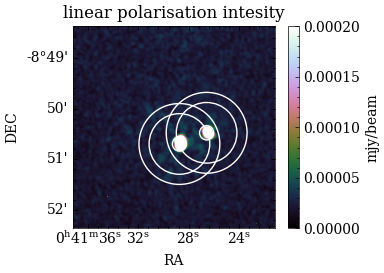

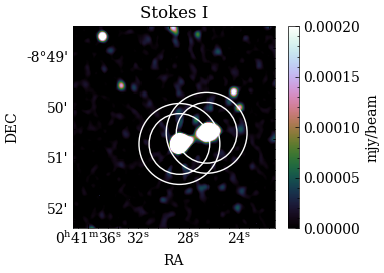

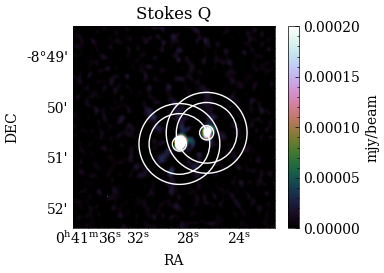

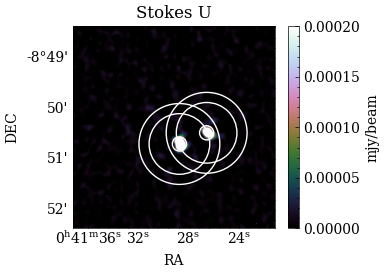

In [7]:
plt.figure()
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
map1 = plt.imshow(lin_pol_freqmean, cmap='cubehelix',vmin=0, vmax=0.0002, interpolation='nearest')
plt.colorbar(map1, label = 'mjy/beam')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.xlim(1950,2150)
plt.ylim(3150,3350)
apertures.plot(color='white')
annulus.plot(color='white')
plt.title('linear polarisation intesity')
plt.savefig(fname='mean_lin_pol_image.pdf', dpi = 150)
plt.show()

plt.figure()
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
map1 = plt.imshow(I_freqmean, cmap='cubehelix',vmin=0, vmax=0.0002, interpolation='nearest')
plt.colorbar(map1, label = 'mjy/beam')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.xlim(1950,2150)
plt.ylim(3150,3350)
apertures.plot(color='white')
annulus.plot(color='white')
plt.title('Stokes I')
plt.savefig(fname='mean_Stokes_I_image.pdf', dpi = 150)
plt.show()

plt.figure()
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
map1 = plt.imshow(Q_freqmean, cmap='cubehelix',vmin=0, vmax=0.0002, interpolation='nearest')
plt.colorbar(map1, label = 'mjy/beam')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.xlim(1950,2150)
plt.ylim(3150,3350)
apertures.plot(color='white')
annulus.plot(color='white')
plt.title('Stokes Q')
plt.savefig(fname='mean_Stokes_Q_image.pdf', dpi = 150)
plt.show()

plt.figure()
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
map1 = plt.imshow(U_freqmean, cmap='cubehelix',vmin=0, vmax=0.0002, interpolation='nearest')
plt.colorbar(map1, label = 'mjy/beam')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.xlim(1950,2150)
plt.ylim(3150,3350)
apertures.plot(color='white')
annulus.plot(color='white')
plt.title('Stokes U')
plt.savefig(fname='mean_Stokes_U_image.pdf', dpi = 150)
plt.show()





In [8]:
print(linpol_hdu.header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 3617                                                  NAXIS2  =                 3617                                                  NAXIS3  =                   12                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [9]:
FWHM_major_axis = 2.140992E-03*c.degree # Information from the header
FWHM_minor_axis = 1.972343E-03*c.degree
pixsize = 3.317774E-04*c.degree
delta_cal = 0.05
N = 1

def photometry(data, apers, annulus_local, psize, min_ax, maj_ax, n, delta_cal=0.05, N=1):
    # This function calculates the flux from a source
    data_local_intensity = data*4*np.log(2)/(np.pi*maj_ax*min_ax) # Converts Jy/beam to Jy/sr
    phot_table = aperture_photometry(data_local_intensity, apers) # This is a pre build function
    flux = phot_table['aperture_sum']*(psize**2)
    annulus_masks = annulus_local.to_mask()
    backgr_error = np.zeros(n)
    for i in range(n):
        annulus_data = annulus_masks[i].multiply(data)
        annulus_data_1d = annulus_data[annulus_masks[i].data != 0.]
        backgr_error[i] = np.std(annulus_data_1d) # error per beam due to background
    flux_error = np.sqrt((backgr_error*np.sqrt(N))**2 + (delta_cal*flux)**2)
    phot_table['flux'] = flux
    phot_table['flux_err'] = flux_error
    return phot_table

phot_table = photometry(I_freqmean, apertures, annulus, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))
print(phot_table)

 id      xcenter       ...         flux                flux_err      
           pix         ...                                           
--- ------------------ ... -------------------- ---------------------
  1 2055.5426738092174 ... 0.024458329161694038 0.0014514674200094841
  2  2082.471051368293 ... 0.014605446400166084 0.0016800003264865096


In [10]:

I_table, I_table_err = np.zeros((12, len(sources))), np.zeros((12, len(sources)))
Q_table, Q_table_err = np.zeros((12, len(sources))), np.zeros((12, len(sources)))
U_table, U_table_err = np.zeros((12, len(sources))), np.zeros((12, len(sources)))

In [11]:
for n in range(12):
    I_slice_phot_compar = photometry(I_data[n], apertures, annulus, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))
    Q_slice_phot_compar = photometry(Q_data[n], apertures, annulus, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))
    U_slice_phot_compar = photometry(U_data[n], apertures, annulus, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))
    print(Q_slice_phot_compar)
    for i in range(len(sources)):
        I_table[n, i], I_table_err[n, i] = I_slice_phot_compar[i]['flux'], I_slice_phot_compar[i]['flux_err']
        Q_table[n, i], Q_table_err[n, i] = Q_slice_phot_compar[i]['flux'], Q_slice_phot_compar[i]['flux_err']
        U_table[n, i], U_table_err[n, i] = U_slice_phot_compar[i]['flux'], U_slice_phot_compar[i]['flux_err']
        

 id      xcenter       ...          flux                 flux_err       
           pix         ...                                              
--- ------------------ ... ---------------------- ----------------------
  1 2055.5426738092174 ...  0.0005112139352253458 4.2375267014232136e-05
  2  2082.471051368293 ... 0.00024383401600309076  3.380685667027069e-05
 id      xcenter       ...          flux                flux_err       
           pix         ...                                             
--- ------------------ ... --------------------- ----------------------
  1 2055.5426738092174 ...   0.00078319573338655  5.162278682456512e-05
  2  2082.471051368293 ... 0.0003287412632913999 4.6340461897310866e-05
 id      xcenter       ...          flux                 flux_err      
           pix         ...                                             
--- ------------------ ... ---------------------- ---------------------
  1 2055.5426738092174 ...    0.00096761357091262 5.7037602

In [12]:
print(I_table[:,0])

[0.02987929 0.02917157 0.02839723 0.02757688 0.02650286 0.02600766
 0.02248987 0.021897   0.02080987 0.02069266 0.01990389 0.02017117]


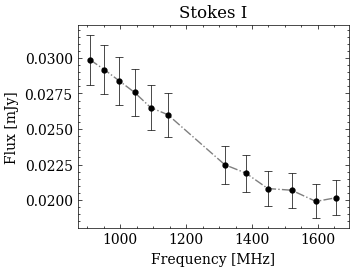

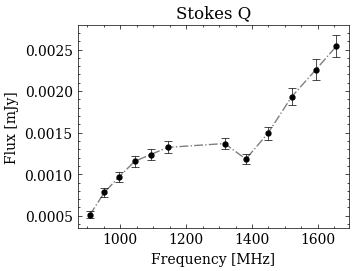

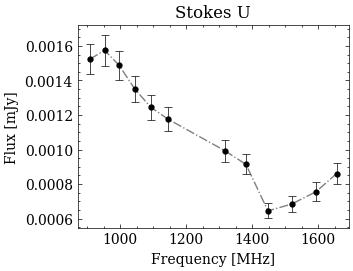

In [13]:
plt.figure()
plt.errorbar(freq_m/1E6, I_table[:,0],yerr= I_table_err[:,0], color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5)
plt.plot(freq_m/1E6, I_table[:,0], 'k-.', alpha=0.5)
plt.ylabel('Flux [mJy]')
plt.xlabel('Frequency [MHz]')
plt.title('Stokes I')
plt.savefig(fname='flux_stokesI.pdf', dpi = 150)
plt.show()

plt.figure()
plt.errorbar(freq_m/1E6, Q_table[:,0],yerr= Q_table_err[:,0], color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5)
plt.plot(freq_m/1E6, Q_table[:,0], 'k-.', alpha=0.5)
plt.ylabel('Flux [mJy]')
plt.xlabel('Frequency [MHz]')
plt.title('Stokes Q')
plt.savefig(fname='flux_stokesQ.pdf', dpi = 150)
plt.show()

plt.figure()
plt.errorbar(freq_m/1E6, U_table[:,0],yerr= U_table_err[:,0], color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5)
plt.plot(freq_m/1E6, U_table[:,0], 'k-.', alpha=0.5)
plt.ylabel('Flux [mJy]')
plt.xlabel('Frequency [MHz]')
plt.title('Stokes U')
plt.savefig(fname='flux_stokesU.pdf', dpi = 150)
plt.show()

In [14]:
pol_ang = 0.5*np.arctan2(U_table[:,0], Q_table[:,0]) # One of the polar coordinates
linear_pol = np.sqrt(Q_table[:,0]**2+U_table[:,0]**2)
deg_pol = linear_pol/I_table[:,0]

pol_ang_err = (Q_table[:,0]*U_table_err[:,0]-U_table[:,0]*Q_table_err[:,0])/(linear_pol**2)
# print(linear_pol)
print(pol_ang_err)
linear_pol_err = (U_table[:,0]*U_table_err[:,0]+Q_table[:,0]*Q_table_err[:,0])/linear_pol
deg_pol_err = np.sqrt(linear_pol_err**2 + I_table_err[:,0]**2)
# print(linear_pol_err)
# print(I_table_err[:,0])

[-0.00825779 -0.00328084 -0.00090309  0.00016198  0.00161918  0.00306458
  0.00495824  0.00580755  0.00567333  0.00519546  0.0061716   0.00486862]


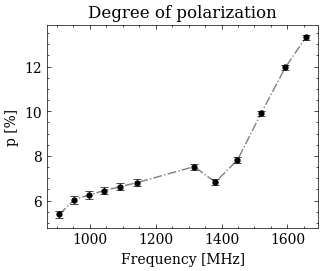

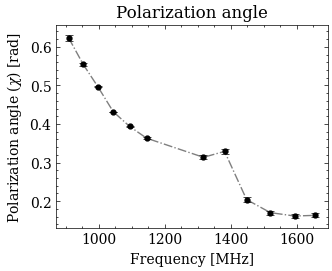

In [15]:
plt.figure()
plt.errorbar(freq_m/1E6, 100*deg_pol,yerr= 100*deg_pol_err, color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5)
plt.plot(freq_m/1E6, 100*linear_pol/I_table[:,0], 'k-.', alpha=0.5)
plt.ylabel('p [%]')
plt.xlabel('Frequency [MHz]')
plt.title('Degree of polarization')
plt.savefig(fname='flux_lin_pol.pdf', dpi = 150)
plt.show()

plt.figure()
plt.errorbar(freq_m/1E6, pol_ang,yerr= np.abs(pol_ang_err), color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5)
plt.plot(freq_m/1E6, pol_ang, 'k-.', alpha=0.5)
plt.ylabel('Polarization angle ($\chi$) [rad] ')
plt.xlabel('Frequency [MHz]')
plt.title('Polarization angle')
plt.savefig(fname='flux_pol_ang.pdf', dpi = 150)
plt.show()

### to do
 - write a for loop where you acces all the individual frequencies of the data set instead of the whole dat aset at once...
 - Get rid of these last functions
 - find out how to get a flux from the intensities

### Here we will run the MCMC code

In [16]:
freq = freq_m/1E9
print(freq[1])

0.952341796875


# Stokes I MCMC

/Users/joppeswart/Library/Python/3.10/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


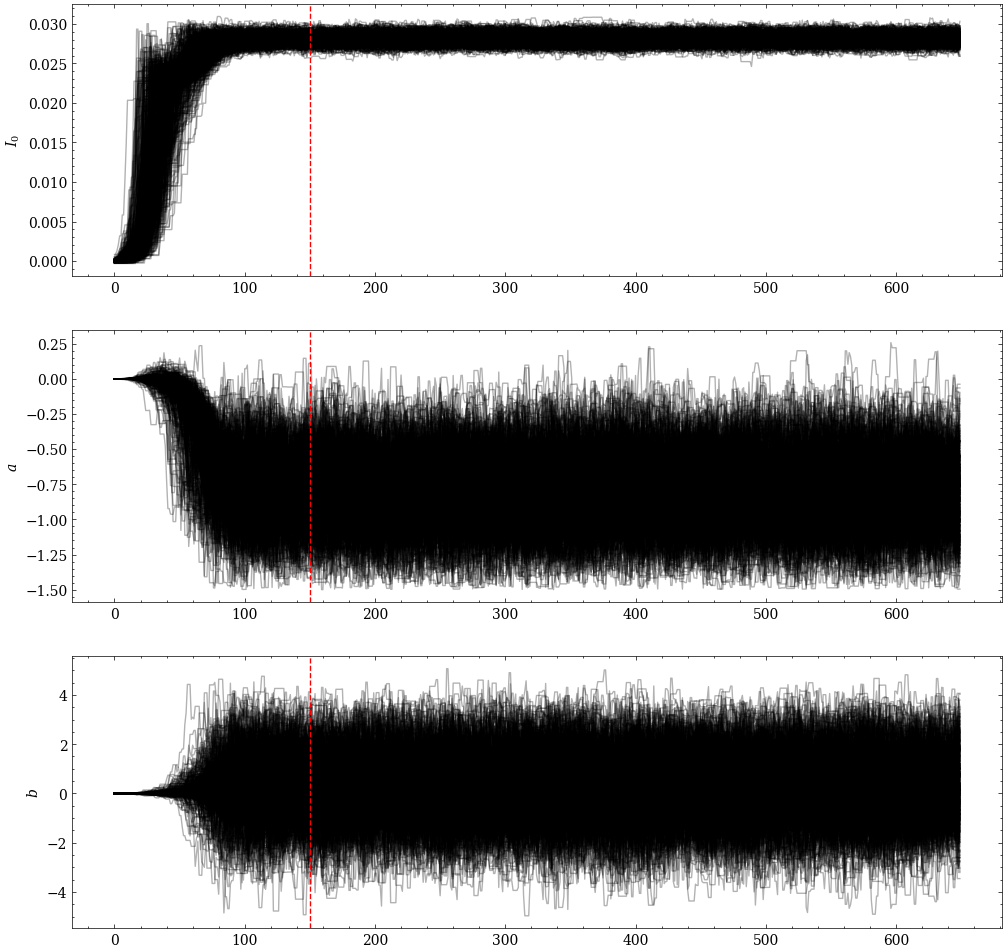

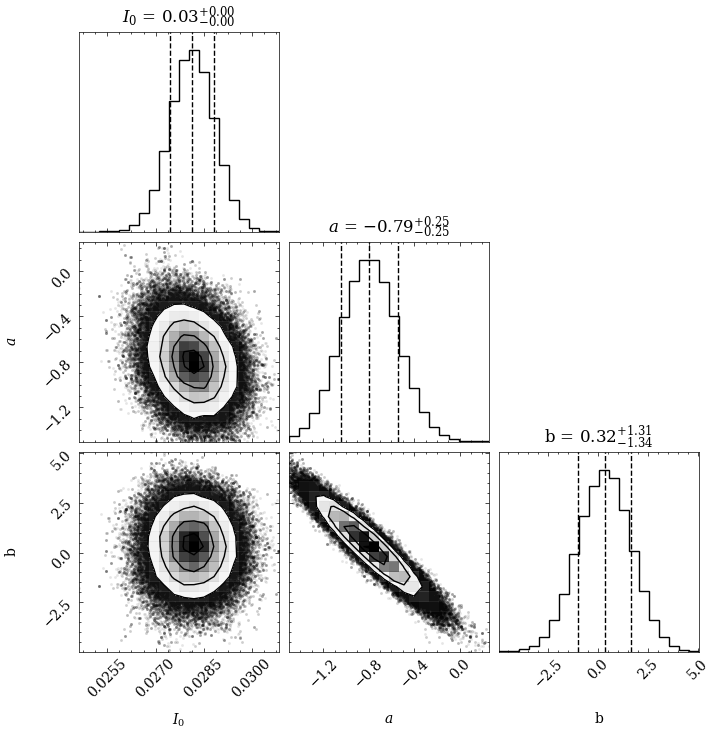

In [17]:
# Define the parameters needed for mcmc StokesI
I_0_guess = 0#Chi2_pl_min[1]
a_guess = 0
b_guess = 0#Chi2_pl_min[2]

#c_guess = Chi_min[3]

x = freq # Lijst met frequenties in GHz
y_obs = I_table[:,0] # data punten 
dy = I_table_err[:,0] # error in de data

def lnL_StokesI(theta, x, y, yerr):
    I_0, a, b = theta
    model_stokes_I = I_0*x**(a + b*np.log10(x))#*u.uJy
    inv_sigma2 = 1.0/(np.power(yerr,2))
    
    return -0.5*(np.sum((y-model_stokes_I)**2*inv_sigma2))

def lnprior_StokesI(theta):
    I_0, a, b = theta
    if 0 < I_0 < 1 and -1.5 < a < 1.5 and -5 < b < 6:
        return 0.0
    return -np.inf

def lnprob_StokesI(theta, x, y, yerr):
    lp_StokesI = lnprior_StokesI(theta)
    if not np.isfinite(lp_StokesI):
        return -np.inf
    return lp_StokesI + lnL_StokesI(theta, x, y, yerr)
    
ndim_StokesI, nwalkers = 3, 500
theta_StokesI_guess = np.array([I_0_guess, a_guess, b_guess])
pos_StokesI = [theta_StokesI_guess + 1e-4*np.random.randn(ndim_StokesI) for i in range(nwalkers)]
sampler_StokesI = emcee.EnsembleSampler(nwalkers, ndim_StokesI, lnprob_StokesI, args=(x, y_obs, dy))
tmp = sampler_StokesI.run_mcmc(pos_StokesI, 650)

fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_size_inches(12,12)
axes[0].plot(sampler_StokesI.chain[:, :, 0].transpose(), color='black', alpha=0.3)
axes[0].set_ylabel(r'$I_0$')
axes[0].axvline(150, ls='dashed', color='red')
axes[1].plot(sampler_StokesI.chain[:, :, 1].transpose(), color='black', alpha=0.3)
axes[1].set_ylabel(r'$a$')
axes[1].axvline(150, ls='dashed', color='red')
axes[2].plot(sampler_StokesI.chain[:, :, 2].transpose(), color='black', alpha=0.3)
axes[2].set_ylabel(r'$b$')
axes[2].axvline(150, ls='dashed', color='red')
fig.savefig('chain_StokesI.pdf', format='pdf')
# plt.close()

samples_StokesI = sampler_StokesI.chain[:, 150:, :].reshape((-1, 3))
# print(samples_StokesI[:,0], samples_StokesI[:,1], samples_StokesI[:,2])
#print(samples.shape)

fig = corner.corner(samples_StokesI, labels=[r"$I_0$", r"$a$", r"b"], quantiles=[0.16, 0.50, 0.84], show_titles=True)#truths=[S_pl_guess, a_pl_guess],)
fig.savefig('corner_StokesI.pdf', format='pdf')
# plt.close()

median_I_0_StokesI = np.percentile(samples_StokesI[:, 0], 50.0)
median_a_StokesI = np.percentile(samples_StokesI[:, 1], 50.0)
median_b_StokesI = np.percentile(samples_StokesI[:, 2], 50.0)

p16_I_0_StokesI = np.percentile(samples_StokesI[:, 0], 16)
p16_a_StokesI = np.percentile(samples_StokesI[:, 1], 16)
p16_b_StokesI = np.percentile(samples_StokesI[:, 2], 16)

p84_I_0_StokesI = np.percentile(samples_StokesI[:, 0], 84)
p84_a_StokesI = np.percentile(samples_StokesI[:, 1], 84)
p84_b_StokesI = np.percentile(samples_StokesI[:, 2], 84)

sigma_I_0_StokesI = 0.5*(p84_I_0_StokesI-p16_I_0_StokesI)
sigma_a_StokesI = 0.5*(p84_a_StokesI-p16_a_StokesI)
sigma_b_StokesI = 0.5*(p84_b_StokesI-p16_b_StokesI)

#print('chi square powerlaw = ', Chi_pl([median_S_pl], [median_a_pl])/(len(frequency)-2))


MCMC_StokesI=np.empty(shape=[len(samples_StokesI[:,0]), 0])
for i in range(len(x)):
    MCMC_StokesI = np.append(MCMC_StokesI, (samples_StokesI[:,0]*x[i]**(samples_StokesI[:,1] + samples_StokesI[:,2]*np.log10(x[i]))).reshape(len(samples_StokesI[:,0]), 1), axis = 1)
#     print(MCMC_StokesI)
    
pl_16 = []
pl_84 = []
for i in range(len(x)):
    pl_16.append(np.percentile(np.sort(MCMC_StokesI[:,i]),16))
    pl_84.append(np.percentile(np.sort(MCMC_StokesI[:,i]),84))

StokesI_16 = np.array(pl_16)#*u.mJy
StokesI_84 = np.array(pl_84)#*u.mJy

def red_chi_StokesI(I_0, a, b):
    chi_StokesI = 0
    model = I_0*x**(a+b*np.log10(x))#*uJy
    for i in range(len(x)):
        chi_StokesI += ((y_obs[i]-model[i])/yerr[i])**2
    red_chi_StokesI = chi_StokesI/(len(x)-3)
    return red_chi_StokesI

# Stokes U MCMC

In [18]:
wave2 = (c.c/freq_m)**2
print(wave2)

[0.10900194 0.09909591 0.09048136 0.08254497 0.07526213 0.06860066
 0.05179874 0.04711316 0.04286202 0.03890331 0.0353758  0.03276538]


/Users/joppeswart/Library/Python/3.10/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


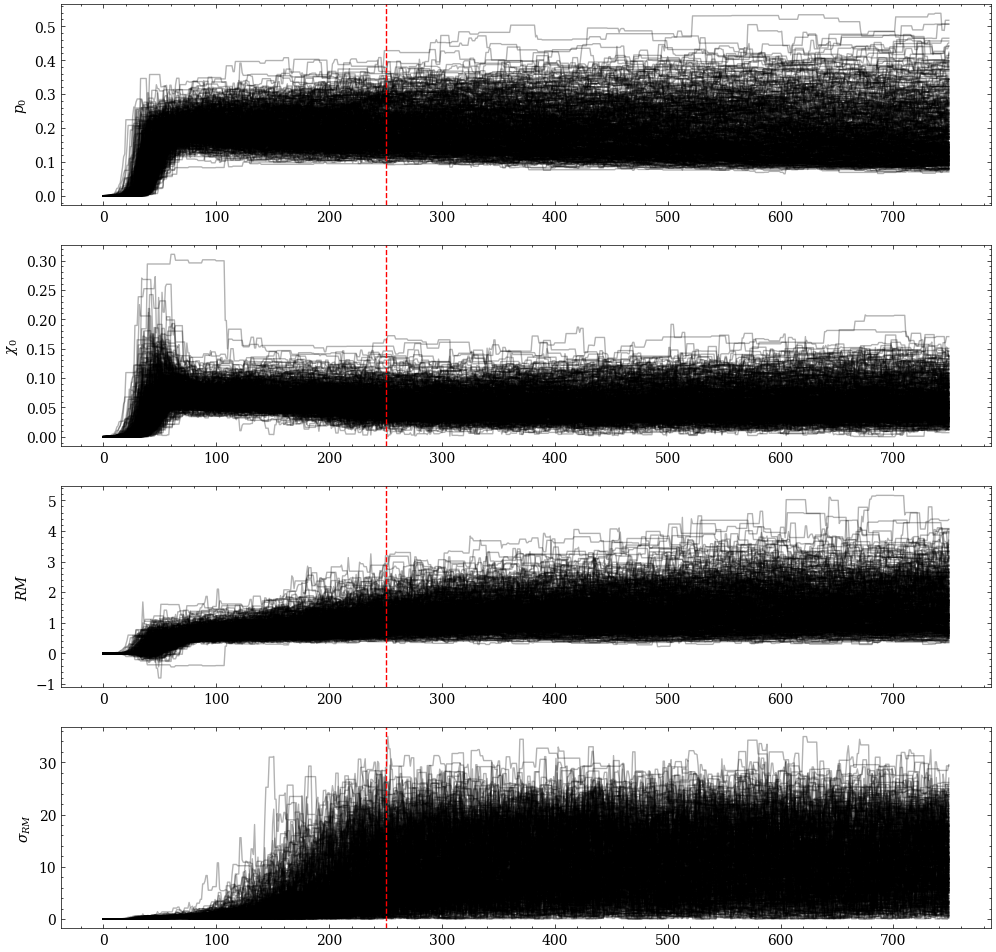

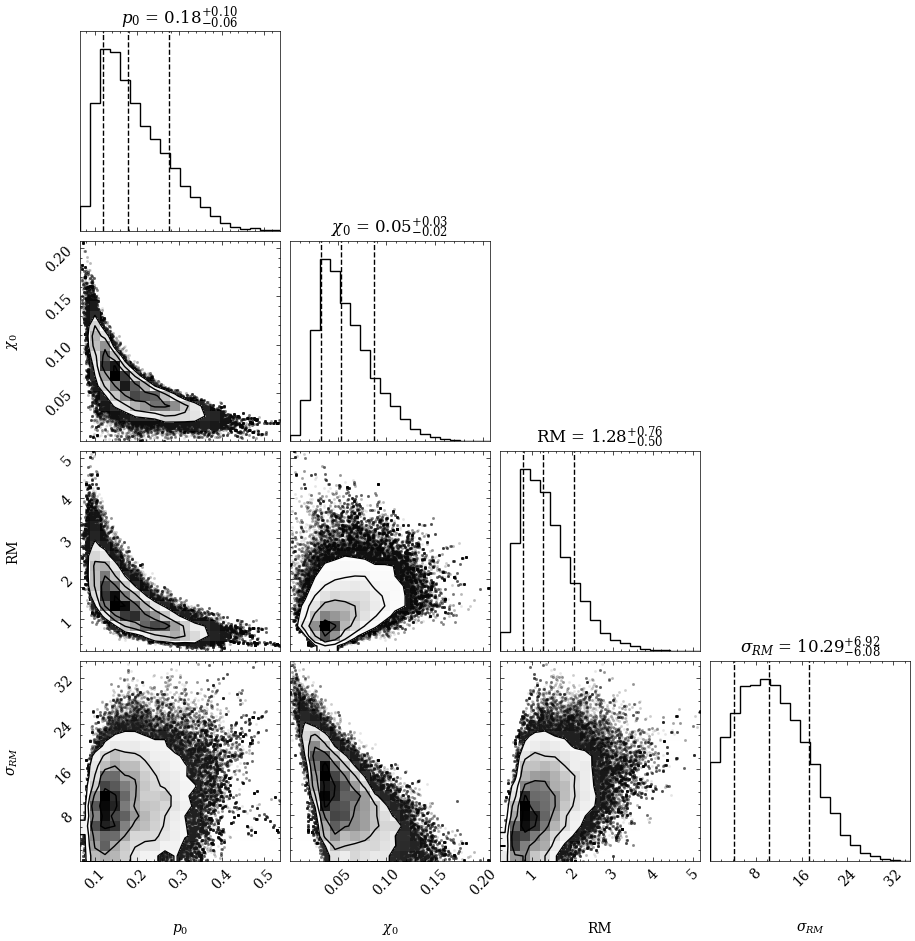

In [24]:
# Define the parameters needed for mcmc StokesU
Stokes_I = median_I_0_StokesI*freq**(median_a_StokesI + median_b_StokesI*np.log10(freq))
p0_guess = 0#Chi2_pl_min[1]
chi0_guess = 0
rm_guess = 0#Chi2_pl_min[2]
sigma_rm_geuss = 0
wave2 = (c.c/freq_m)**2

x = wave2 # Lijst met frequenties in GHz
y_obs = U_table[:,0] # data punten 
dy = U_table_err[:,0] # error in de data

def lnL_StokesU(theta, x, y, yerr):
    p0, chi0, rm, sigma_rm = theta
    model_StokesU = Stokes_I * p0 * np.exp(-2*(sigma_rm)*(x**2)) * np.sin(2*(chi0 + rm*x))
    inv_sigma2 = 1.0/(np.power(yerr,2))
    
    return -0.5*(np.sum((y-model_StokesU)**2*inv_sigma2))

def lnprior_StokesU(theta):
    p0, chi0, rm, sigma_rm = theta
    if 0 < p0 < 1. and 0 < chi0 < 2*np.pi and -400 < rm < 400 and  0 < sigma_rm < 100.:
        return 0.0
    return -np.inf

def lnprob_StokesU(theta, x, y, yerr):
    lp_StokesU = lnprior_StokesU(theta)
    if not np.isfinite(lp_StokesU):
        return -np.inf
    return lp_StokesU + lnL_StokesU(theta, x, y, yerr)
    
ndim_StokesU, nwalkers = 4, 500
theta_StokesU_guess = np.array([p0_guess, chi0_guess, rm_guess, sigma_rm_geuss])
pos_StokesU = [theta_StokesU_guess + 1e-4*np.random.randn(ndim_StokesU) for i in range(nwalkers)]
sampler_StokesU = emcee.EnsembleSampler(nwalkers, ndim_StokesU, lnprob_StokesU, args=(x, y_obs, dy))
tmp = sampler_StokesU.run_mcmc(pos_StokesU, 750)

fig, axes = plt.subplots(ncols=1, nrows=4)
fig.set_size_inches(12,12)
axes[0].plot(sampler_StokesU.chain[:, :, 0].transpose(), color='black', alpha=0.3)
axes[0].set_ylabel(r'$p_0$')
axes[0].axvline(250, ls='dashed', color='red')
axes[1].plot(sampler_StokesU.chain[:, :, 1].transpose(), color='black', alpha=0.3)
axes[1].set_ylabel(r'$\chi_0$')
axes[1].axvline(250, ls='dashed', color='red')
axes[2].plot(sampler_StokesU.chain[:, :, 2].transpose(), color='black', alpha=0.3)
axes[2].set_ylabel(r'$RM$')
axes[2].axvline(250, ls='dashed', color='red')
axes[3].plot(sampler_StokesU.chain[:, :, 3].transpose(), color='black', alpha=0.3)
axes[3].set_ylabel(r'$\sigma_{RM}$')
axes[3].axvline(250, ls='dashed', color='red')
fig.savefig('chain_StokesU.pdf', format='pdf')
# plt.close()

samples_StokesU = sampler_StokesU.chain[:, 250:, :].reshape((-1, 4))
# print(samples_StokesU[:,0], samples_StokesU[:,1], samples_StokesU[:,2])
#print(samples.shape)

fig = corner.corner(samples_StokesU, labels=[r"$p_0$", r"$\chi_0$", r"RM", r"$\sigma_{RM}$"], quantiles=[0.16, 0.50, 0.84], show_titles=True)#truths=[S_pl_guess, a_pl_guess],)
fig.savefig('corner_StokesU.pdf', format='pdf')
# plt.close()

median_p0_StokesU = np.percentile(samples_StokesU[:, 0], 50.0)
median_chi0_StokesU = np.percentile(samples_StokesU[:, 1], 50.0)
median_RM_StokesU = np.percentile(samples_StokesU[:, 2], 50.0)
median_sigmaRM_StokesU = np.percentile(samples_StokesU[:, 3], 50.0)

p16_p0_StokesU = np.percentile(samples_StokesU[:, 0], 16)
p16_chi0_StokesU = np.percentile(samples_StokesU[:, 1], 16)
p16_RM_StokesU = np.percentile(samples_StokesU[:, 2], 16)
p16_sigmaRM_StokesU = np.percentile(samples_StokesU[:, 3], 16)

p84_p0_StokesU = np.percentile(samples_StokesU[:, 0], 84)
p84_chi0_StokesU = np.percentile(samples_StokesU[:, 1], 84)
p84_RM_StokesU = np.percentile(samples_StokesU[:, 2], 84)
p84_sigmaRM_StokesU = np.percentile(samples_StokesU[:, 3], 84)

sigma_p0_StokesU = 0.5*(p84_p0_StokesU-p16_p0_StokesU)
sigma_chi0_StokesU = 0.5*(p84_chi0_StokesU-p16_chi0_StokesU)
sigma_RM_StokesU = 0.5*(p84_RM_StokesU-p16_RM_StokesU)
sigma_sigmaRM_StokesU = 0.5*(p84_sigmaRM_StokesU-p16_sigmaRM_StokesU)

#print('chi square powerlaw = ', Chi_pl([median_S_pl], [median_a_pl])/(len(frequency)-2))


MCMC_StokesU=np.empty(shape=[len(samples_StokesU[:,0]), 0])
for i in range(len(x)):
    MCMC_StokesU = np.append(MCMC_StokesU, (Stokes_I[i] * samples_StokesU[:,0] * np.exp(-2*(samples_StokesU[:,3])*(x[i]**2)) * np.sin(2*(samples_StokesU[:,1] + samples_StokesU[:,2]*x[i]))).reshape(len(samples_StokesU[:,0]), 1), axis = 1)
#     print(MCMC_StokesU)
    
pl_16 = []
pl_84 = []
for i in range(len(x)):
    pl_16.append(np.percentile(np.sort(MCMC_StokesU[:,i]),16))
    pl_84.append(np.percentile(np.sort(MCMC_StokesU[:,i]),84))

StokesU_16 = np.array(pl_16)#*u.mJy
StokesU_84 = np.array(pl_84)#*u.mJy

def red_chi_StokesU(p0, chi0, RM, sigma_RM):
    chi_StokesU = 0
    model = Stokes_I * p0 * np.exp(-2*(sigma_RM)*(x**2)) * np.sin(2*(chi0 + RM*x))
    for i in range(len(x)):
        chi_StokesU += ((y_obs[i]-model[i])/yerr[i])**2
    red_chi_StokesU = chi_StokesU/(len(x)-4)
    return red_chi_StokesU

# Stokes Q/U MCMC

/Users/joppeswart/Library/Python/3.10/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/_t/vv83f9j10bx92j48kss09c8m0000gn/T/ipykernel_9209/4047817252.py:20: RuntimeWarning: overflow encountered in square
  return -0.5*(np.sum(((y1-model1)/yerr1)**2 + ((y2-model2)/yerr2)**2))
/var/folders/_t/vv83f9j10bx92j48kss09c8m0000gn/T/ipykernel_9209/4047817252.py:17: RuntimeWarning: overflow encountered in exp
  model1 = Stokes_I * p0 * np.exp(-2*(sigma_rm)*(x**2)) * np.sin(2*(chi0 + rm*x)) #Stokes U
/var/folders/_t/vv83f9j10bx92j48kss09c8m0000gn/T/ipykernel_9209/4047817252.py:18: RuntimeWarning: overflow encountered in exp
  model2 = Stokes_I * p0 * np.exp(-2*(sigma_rm)*(x**2)) * np.cos(2*(chi0 + rm*x)) #Stokes Q
/var/folders/_t/vv83f9j10bx92j48kss09c8m0000gn/T/ipykernel_9209/4047817252.py:20: RuntimeWarning: overflow encountered in divide
  return -0.5*(np.sum(((y1-model1)/yerr1)**

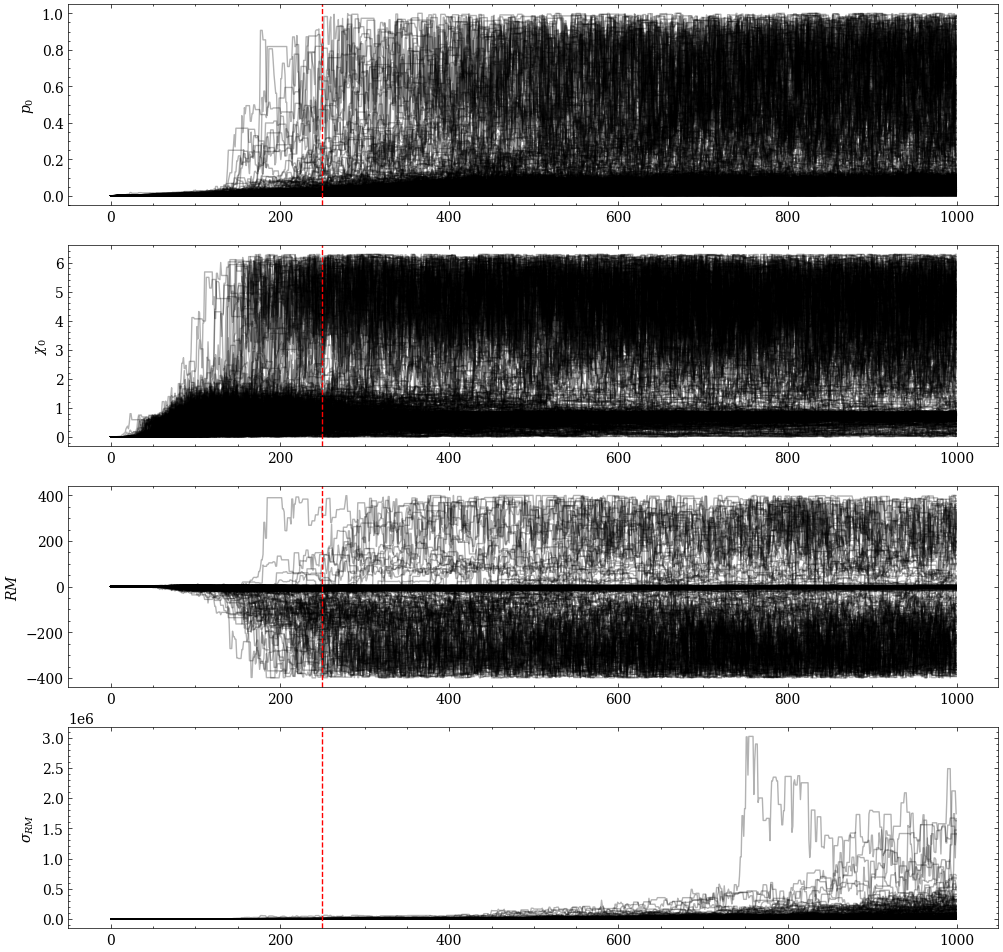

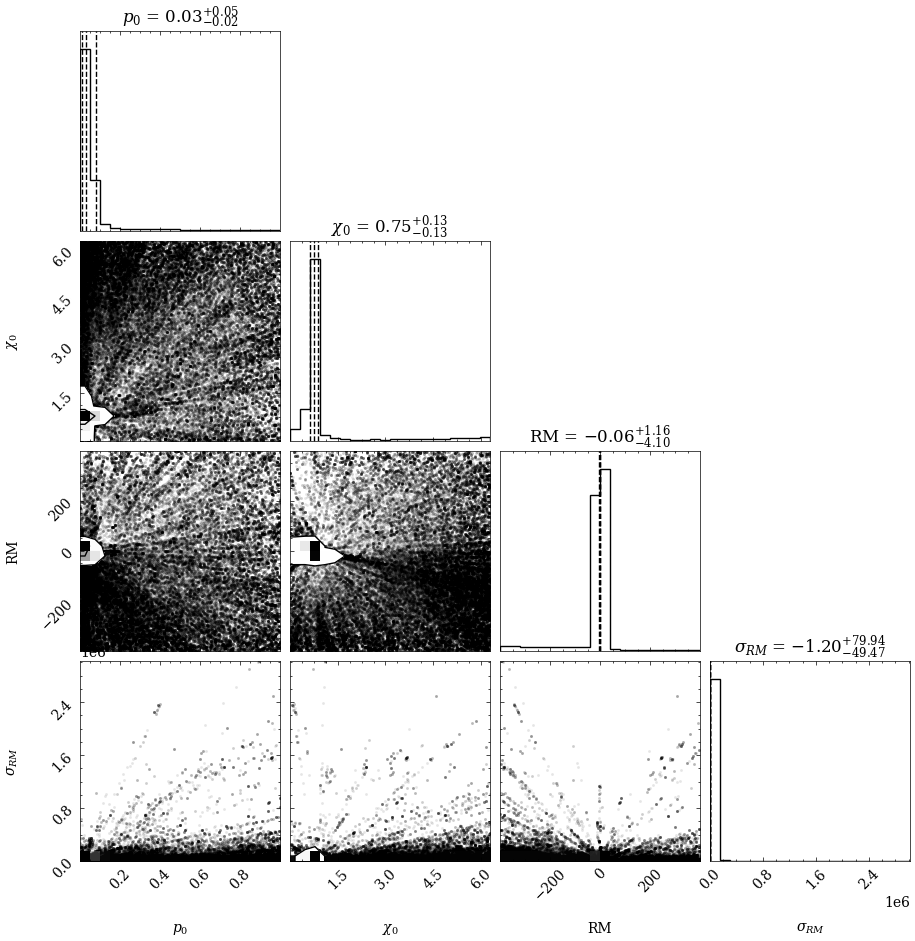

In [31]:
# Define the parameters needed for mcmc StokesQ
Stokes_I = median_I_0_StokesI*freq**(median_a_StokesI + median_b_StokesI*np.log10(freq))
p0_guess = 0#Chi2_pl_min[1]
chi0_guess = 0
rm_guess = 0#Chi2_pl_min[2]
sigma_rm_geuss = 0
wave2 = (c.c/freq_m)**2

x = wave2 # Lijst met frequenties in GHz
y_U = U_table[:,0] # data punten 
dy_U = U_table_err[:,0] # error in de data
y_Q = Q_table[:,0] # data punten 
dy_Q = Q_table_err[:,0] # error in de data

def lnL(theta, x, y1, y2, yerr1, yerr2):
    p0, chi0, rm, sigma_rm = theta
    model1 = Stokes_I * p0 * np.exp(-2*(sigma_rm)*(x**2)) * np.sin(2*(chi0 + rm*x)) #Stokes U
    model2 = Stokes_I * p0 * np.exp(-2*(sigma_rm)*(x**2)) * np.cos(2*(chi0 + rm*x)) #Stokes Q
    
    return -0.5*(np.sum(((y1-model1)/yerr1)**2 + ((y2-model2)/yerr2)**2))

def lnprior(theta):
    p0, chi0, rm, sigma_rm = theta
    if 0 < p0 < 1. and 0 < chi0 < 2*np.pi and -400 < rm < 400:# and  0 < sigma_rm < 100.:
        return 0.0
    return -np.inf

def lnprob(theta, x, y1, y2, yerr1, yerr2):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(theta, x, y1, y2, yerr1, yerr2)
    
ndim, nwalkers = 4, 1000
theta_guess = np.array([p0_guess, chi0_guess, rm_guess, sigma_rm_geuss])
pos = [theta_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_U, dy_U, y_Q, dy_Q))
tmp = sampler.run_mcmc(pos, 1000)

fig, axes = plt.subplots(ncols=1, nrows=4)
fig.set_size_inches(12,12)
axes[0].plot(sampler.chain[:, :, 0].transpose(), color='black', alpha=0.3)
axes[0].set_ylabel(r'$p_0$')
axes[0].axvline(250, ls='dashed', color='red')
axes[1].plot(sampler.chain[:, :, 1].transpose(), color='black', alpha=0.3)
axes[1].set_ylabel(r'$\chi_0$')
axes[1].axvline(250, ls='dashed', color='red')
axes[2].plot(sampler.chain[:, :, 2].transpose(), color='black', alpha=0.3)
axes[2].set_ylabel(r'$RM$')
axes[2].axvline(250, ls='dashed', color='red')
axes[3].plot(sampler.chain[:, :, 3].transpose(), color='black', alpha=0.3)
axes[3].set_ylabel(r'$\sigma_{RM}$')
axes[3].axvline(250, ls='dashed', color='red')
fig.savefig('chain.pdf', format='pdf')
# plt.close()

samples = sampler.chain[:, 250:, :].reshape((-1, 4))
# print(samples[:,0], samples[:,1], samples[:,2])
#print(samples.shape)

fig = corner.corner(samples, labels=[r"$p_0$", r"$\chi_0$", r"RM", r"$\sigma_{RM}$"], quantiles=[0.16, 0.50, 0.84], show_titles=True)#truths=[S_pl_guess, a_pl_guess],)
fig.savefig('corner.pdf', format='pdf')
# plt.close()

median_p0 = np.percentile(samples[:, 0], 50.0)
median_chi0 = np.percentile(samples[:, 1], 50.0)
median_RM = np.percentile(samples[:, 2], 50.0)
median_sigmaRM = np.percentile(samples[:, 3], 50.0)

p16_p0 = np.percentile(samples[:, 0], 16)
p16_chi0 = np.percentile(samples[:, 1], 16)
p16_RM = np.percentile(samples[:, 2], 16)
p16_sigmaRM = np.percentile(samples[:, 3], 16)

p84_p0 = np.percentile(samples[:, 0], 84)
p84_chi0 = np.percentile(samples[:, 1], 84)
p84_RM = np.percentile(samples[:, 2], 84)
p84_sigmaRM = np.percentile(samples[:, 3], 84)

sigma_p0 = 0.5*(p84_p0-p16_p0)
sigma_chi0 = 0.5*(p84_chi0-p16_chi0)
sigma_RM = 0.5*(p84_RM-p16_RM)
sigma_sigmaRM = 0.5*(p84_sigmaRM-p16_sigmaRM)

#print('chi square powerlaw = ', Chi_pl([median_S_pl], [median_a_pl])/(len(frequency)-2))


MCMC_U=np.empty(shape=[len(samples[:,0]), 0])
MCMC_Q=np.empty(shape=[len(samples[:,0]), 0])
for i in range(len(x)):
    MCMC_U = np.append(MCMC_U, (Stokes_I[i] * samples[:,0] * np.exp(-2*(samples[:,3])*(x[i]**2)) * np.sin(2*(samples[:,1] + samples[:,2]*x[i]))).reshape(len(samples[:,0]), 1), axis = 1)
    MCMC_Q = np.append(MCMC_Q, (Stokes_I[i] * samples[:,0] * np.exp(-2*(samples[:,3])*(x[i]**2)) * np.cos(2*(samples[:,1] + samples[:,2]*x[i]))).reshape(len(samples[:,0]), 1), axis = 1)

    
U_16 = []
U_84 = []
Q_16 = []
Q_84 = []
for i in range(len(x)):
    U_16.append(np.percentile(np.sort(MCMC_U[:,i]),16))
    U_84.append(np.percentile(np.sort(MCMC_U[:,i]),84))
    Q_16.append(np.percentile(np.sort(MCMC_Q[:,i]),16))
    Q_84.append(np.percentile(np.sort(MCMC_Q[:,i]),84))

StokesQ_16 = np.array(Q_16)#*u.mJy
StokesQ_84 = np.array(Q_84)#*u.mJy
StokesU_16 = np.array(U_16)#*u.mJy
StokesU_84 = np.array(U_84)#*u.mJy

# def red_chi(p0, chi0, RM, sigma_RM):
#     chi = 0
#     model = Stokes_I * p0 * np.exp(-2*(sigma_RM)*(x**2)) * np.cos(2*(chi0 + RM*x))
#     for i in range(len(x)):
#         chi += ((y_obs[i]-model[i])/yerr[i])**2
#     red_chi = chi/(len(x)-4)
#     return red_chi

# degree of polarization MCMC

In [21]:
# # Define the parameters needed for mcmc
# Stokes_I = median_I_0_StokesI*x**(median_a_StokesI + median_b_StokesI*np.log10(x))
# p0_guess = 0#Chi2_pl_min[1]
# chi0_guess = 0
# rm_guess = 0#Chi2_pl_min[2]
# sigma_rm_geuss = 0
# a_guess = 0
# b_guess = 0 
# I_0_guess = 0
# wave2 = (c.c/freq_m)**2

# x = wave2 # Lijst met frequenties in GHz
# y_obs = deg_pol # data punten 
# dy = deg_pol_err # error in de data

# def Q(p0, chi0, rm , sigma_rm):
#     Q = Stokes_I * p0 * np.exp(-2*(sigma_rm)*(x**2)) * np.cos(2*(chi0 + rm*x))
#     return Q

# def U(p0, chi0, rm , sigma_rm):
#     U = Stokes_I * p0 * np.exp(-2*(sigma_rm)*(x**2)) * np.sin(2*(chi0 + rm*x))
#     return U

# def I(I_0, a, b):
#     I = I_0*(freq_m/1E9)**(a + b*np.log10(freq_m/1E9))
#     return I


# def lnL_pol_deg(theta, x, y, yerr):
#     p0, chi0, rm, sigma_rm, I_0, a, b = theta
#     model_pol_deg = np.sqrt(Q(p0, chi0, rm , sigma_rm)**2 + U(p0, chi0, rm , sigma_rm)**2)/I(I_0, a, b)
#     inv_sigma2 = 1.0/(np.power(yerr,2))
    
#     return -0.5*(np.sum((y-model_pol_deg)**2*inv_sigma2))

# def lnprior_pol_deg(theta):
#     p0, chi0, rm, sigma_rm, I_0, a, b = theta
#     if 0 < p0 < 1. and 0 < chi0 < np.pi and -400 < rm < 400 and  0 < sigma_rm < 100. and 0 < I_0 < 1 and -1.5 < a < 1.5 and -5 < b < 6:
#         return 0.0
#     return -np.inf

# def lnprob_pol_deg(theta, x, y, yerr):
#     lp_pol_deg = lnprior_pol_deg(theta)
#     if not np.isfinite(lp_pol_deg):
#         return -np.inf
#     return lp_pol_deg + lnL_pol_deg(theta, x, y, yerr)
    
# ndim_pol_deg, nwalkers = 7, 500
# theta_pol_deg_guess = np.array([p0_guess, chi0_guess, rm_guess, sigma_rm_geuss, I_0_guess, a_guess, b_guess])
# pos_pol_deg = [theta_pol_deg_guess + 1e-4*np.random.randn(ndim_pol_deg) for i in range(nwalkers)]
# sampler_pol_deg = emcee.EnsembleSampler(nwalkers, ndim_pol_deg, lnprob_pol_deg, args=(x, y_obs, dy))
# tmp = sampler_pol_deg.run_mcmc(pos_pol_deg, 750)

# fig, axes = plt.subplots(ncols=1, nrows=7)
# fig.set_size_inches(12,12)
# axes[0].plot(sampler_pol_deg.chain[:, :, 0].transpose(), color='black', alpha=0.3)
# axes[0].set_ylabel(r'$p_0$')
# axes[0].axvline(250, ls='dashed', color='red')
# axes[1].plot(sampler_pol_deg.chain[:, :, 1].transpose(), color='black', alpha=0.3)
# axes[1].set_ylabel(r'$\chi_0$')
# axes[1].axvline(250, ls='dashed', color='red')
# axes[2].plot(sampler_pol_deg.chain[:, :, 2].transpose(), color='black', alpha=0.3)
# axes[2].set_ylabel(r'$RM$')
# axes[2].axvline(250, ls='dashed', color='red')
# axes[3].plot(sampler_pol_deg.chain[:, :, 3].transpose(), color='black', alpha=0.3)
# axes[3].set_ylabel(r'$\sigma_{RM}$')
# axes[3].axvline(250, ls='dashed', color='red')
# axes[4].plot(sampler_pol_deg.chain[:, :, 0].transpose(), color='black', alpha=0.3)
# axes[4].set_ylabel(r'$I_0$')
# axes[4].axvline(150, ls='dashed', color='red')
# axes[5].plot(sampler_pol_deg.chain[:, :, 1].transpose(), color='black', alpha=0.3)
# axes[5].set_ylabel(r'$a$')
# axes[5].axvline(150, ls='dashed', color='red')
# axes[6].plot(sampler_pol_deg.chain[:, :, 2].transpose(), color='black', alpha=0.3)
# axes[6].set_ylabel(r'$b$')
# axes[6].axvline(150, ls='dashed', color='red')
# fig.savefig('chain_pol_deg.pdf', format='pdf')
# # plt.close()

# samples_pol_deg = sampler_pol_deg.chain[:, 250:, :].reshape((-1, 7))
# # print(samples_pol_deg[:,0], samples_pol_deg[:,1], samples_pol_deg[:,2])
# #print(samples.shape)

# fig = corner.corner(samples_pol_deg, labels=[r"$p_0$", r"$\chi_0$", r"RM", r"$\sigma_{RM}$",r"$I_0$", r"$a$", r"b"], quantiles=[0.16, 0.50, 0.84], show_titles=True)#truths=[S_pl_guess, a_pl_guess],)
# fig.savefig('corner_pol_deg.pdf', format='pdf')
# # plt.close()

# median_p0_pol_deg = np.percentile(samples_pol_deg[:, 0], 50.0)
# median_chi0_pol_deg = np.percentile(samples_pol_deg[:, 1], 50.0)
# median_RM_pol_deg = np.percentile(samples_pol_deg[:, 2], 50.0)
# median_sigmaRM_pol_deg = np.percentile(samples_pol_deg[:, 3], 50.0)
# median_I_0_pol_deg = np.percentile(samples_pol_deg[:, 4], 50.0)
# median_a_pol_deg = np.percentile(samples_pol_deg[:, 5], 50.0)
# median_b_pol_deg = np.percentile(samples_pol_deg[:, 6], 50.0)

# p16_p0_pol_deg = np.percentile(samples_pol_deg[:, 0], 16)
# p16_chi0_pol_deg = np.percentile(samples_pol_deg[:, 1], 16)
# p16_RM_pol_deg = np.percentile(samples_pol_deg[:, 2], 16)
# p16_sigmaRM_pol_deg = np.percentile(samples_pol_deg[:, 3], 16)
# p16_I_0_pol_deg = np.percentile(samples_pol_deg[:, 4], 16)
# p16_a_pol_deg = np.percentile(samples_pol_deg[:, 5], 16)
# p16_b_pol_deg = np.percentile(samples_pol_deg[:, 6], 16)


# p84_p0_pol_deg = np.percentile(samples_pol_deg[:, 0], 84)
# p84_chi0_pol_deg = np.percentile(samples_pol_deg[:, 1], 84)
# p84_RM_pol_deg = np.percentile(samples_pol_deg[:, 2], 84)
# p84_sigmaRM_pol_deg = np.percentile(samples_pol_deg[:, 3], 84)
# p84_I_0_pol_deg = np.percentile(samples_pol_deg[:, 4], 84)
# p84_a_pol_deg = np.percentile(samples_pol_deg[:, 5], 84)
# p84_b_pol_deg = np.percentile(samples_pol_deg[:, 6], 84)

# sigma_p0_pol_deg = 0.5*(p84_p0_pol_deg-p16_p0_pol_deg)
# sigma_chi0_pol_deg = 0.5*(p84_chi0_pol_deg-p16_chi0_pol_deg)
# sigma_RM_pol_deg = 0.5*(p84_RM_pol_deg-p16_RM_pol_deg)
# sigma_sigmaRM_pol_deg = 0.5*(p84_sigmaRM_pol_deg-p16_sigmaRM_pol_deg)
# sigma_I_0_pol_deg = 0.5*(p84_I_0_pol_deg-p16_I_0_pol_deg)
# sigma_a_pol_deg = 0.5*(p84_a_pol_deg-p16_a_pol_deg)
# sigma_b_pol_deg = 0.5*(p84_b_pol_deg-p16_b_pol_deg)

# #print('chi square powerlaw = ', Chi_pl([median_S_pl], [median_a_pl])/(len(frequency)-2))


# MCMC_pol_deg=np.empty(shape=[len(samples_pol_deg[:,0]), 0])
# for i in range(len(x)):
#     MCMC_pol_deg = np.append(MCMC_pol_deg,(np.sqrt(Q(median_p0_pol_deg, median_chi0_pol_deg, median_RM_pol_deg , median_sigmaRM_pol_deg)**2 + \
#                                                    U(median_p0_pol_deg, median_chi0_pol_deg, median_RM_pol_deg , median_sigmaRM_pol_deg)**2)/I(median_I_0_pol_deg, median_a_pol_deg, median_b_pol_deg) ).reshape(len(samples_pol_deg[:,0]), 1), axis = 1)
# #     print(MCMC_pol_deg)
    
# pl_16 = []
# pl_84 = []
# for i in range(len(x)):
#     pl_16.append(np.percentile(np.sort(MCMC_pol_deg[:,i]),16))
#     pl_84.append(np.percentile(np.sort(MCMC_pol_deg[:,i]),84))

# pol_deg_16 = np.array(pl_16)#*u.mJy
# pol_deg_84 = np.array(pl_84)#*u.mJy

# def red_chi_pol_deg(p0, chi0, RM, sigma_RM, I_0, a, b):
#     chi_pol_deg = 0
#     model = np.sqrt(Q(p0, chi0, RM , sigma_RM)**2 + U(p0, chi0, RM , sigma_RM)**2)/I(I_0, a, b)
#     for i in range(len(x)):
#         chi_pol_deg += ((y_obs[i]-model[i])/yerr[i])**2
#     red_chi_pol_deg = chi_pol_deg/(len(x)-7)
#     return red_chi_pol_deg

# Pol angle MCMC

/Users/joppeswart/Library/Python/3.10/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


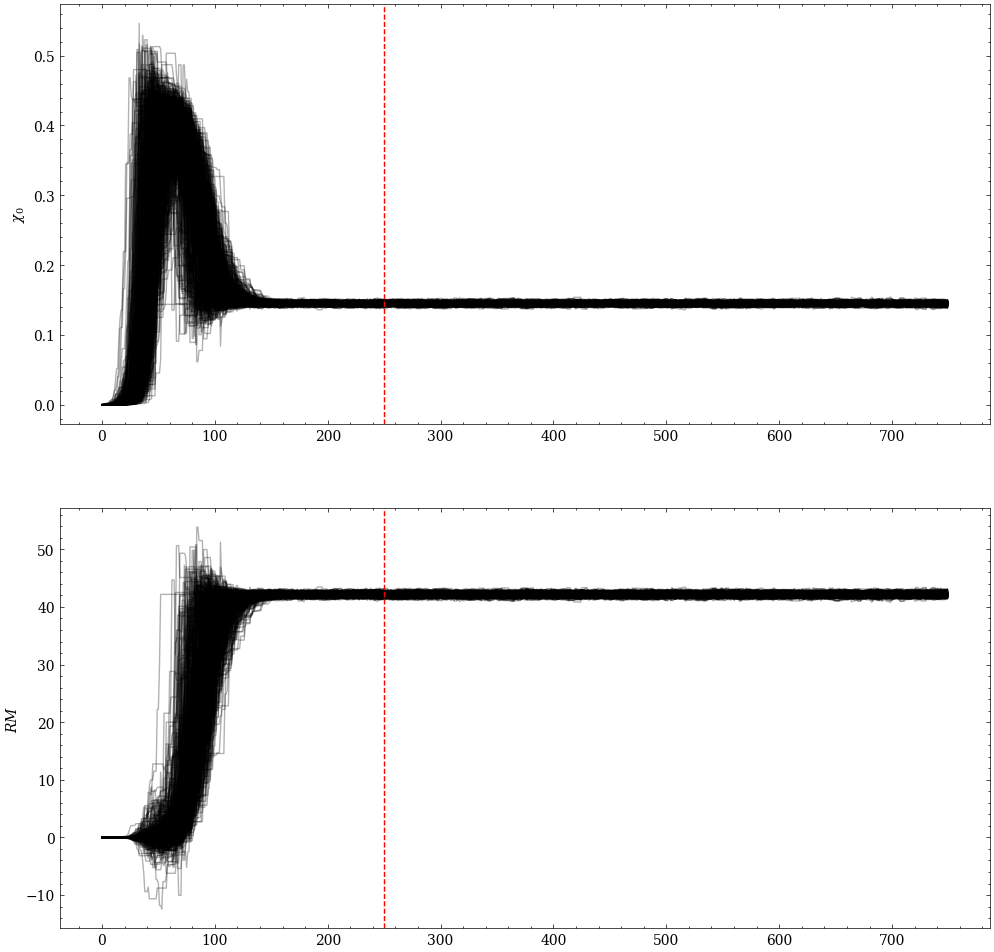

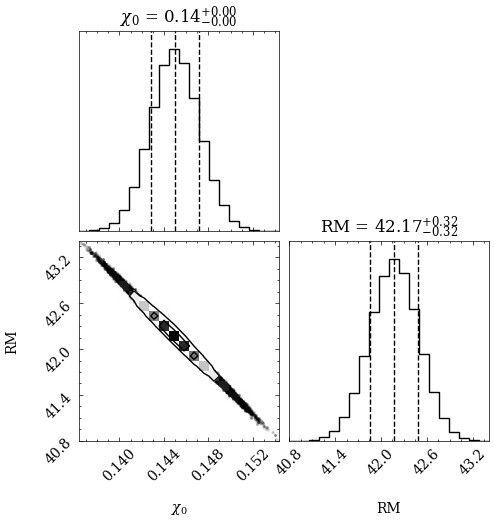

In [22]:
# Define the parameters needed for mcmc

chi0_guess = 0
rm_guess = 0#Chi2_pl_min[2]
wave2 = (c.c/freq_m)**2

x = wave2 # Lijst met frequenties in GHz
y_obs = pol_ang # data punten 
dy = pol_ang_err # error in de data

def lnL_pol_ang(theta, x, y, yerr):
    chi0, rm,  = theta
    model_pol_ang = chi0 + wave2**2*rm
    inv_sigma2 = 1.0/(np.power(yerr,2))
    
    return -0.5*(np.sum((y-model_pol_ang)**2*inv_sigma2))

def lnprior_pol_ang(theta):
    chi0, rm = theta
    if 0 < chi0 < np.pi and -400 < rm < 400:
        return 0.0
    return -np.inf

def lnprob_pol_ang(theta, x, y, yerr):
    lp_pol_ang = lnprior_pol_ang(theta)
    if not np.isfinite(lp_pol_ang):
        return -np.inf
    return lp_pol_ang + lnL_pol_ang(theta, x, y, yerr)
    
ndim_pol_ang, nwalkers = 2, 500
theta_pol_ang_guess = np.array([chi0_guess, rm_guess])
pos_pol_ang = [theta_pol_ang_guess + 1e-4*np.random.randn(ndim_pol_ang) for i in range(nwalkers)]
sampler_pol_ang = emcee.EnsembleSampler(nwalkers, ndim_pol_ang, lnprob_pol_ang, args=(x, y_obs, dy))
tmp = sampler_pol_ang.run_mcmc(pos_pol_ang, 750)

fig, axes = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(12,12)
axes[0].plot(sampler_pol_ang.chain[:, :, 0].transpose(), color='black', alpha=0.3)
axes[0].set_ylabel(r'$\chi_0$')
axes[0].axvline(250, ls='dashed', color='red')
axes[1].plot(sampler_pol_ang.chain[:, :, 1].transpose(), color='black', alpha=0.3)
axes[1].set_ylabel(r'$RM$')
axes[1].axvline(250, ls='dashed', color='red')
fig.savefig('chain_pol_ang.pdf', format='pdf')
# plt.close()

samples_pol_ang = sampler_pol_ang.chain[:, 250:, :].reshape((-1, 2))
# print(samples_pol_ang[:,0], samples_pol_ang[:,1], samples_pol_ang[:,2])
#print(samples.shape)

fig = corner.corner(samples_pol_ang, labels=[r"$\chi_0$", r"RM"], quantiles=[0.16, 0.50, 0.84], show_titles=True)#truths=[S_pl_guess, a_pl_guess],)
fig.savefig('corner_pol_ang.pdf', format='pdf')
# plt.close()

median_chi0_pol_ang = np.percentile(samples_pol_ang[:, 0], 50.0)
median_RM_pol_ang = np.percentile(samples_pol_ang[:, 1], 50.0)

p16_chi0_pol_ang = np.percentile(samples_pol_ang[:, 0], 16)
p16_RM_pol_ang = np.percentile(samples_pol_ang[:, 1], 16)

p84_chi0_pol_ang = np.percentile(samples_pol_ang[:, 0], 84)
p84_RM_pol_ang = np.percentile(samples_pol_ang[:, 1], 84)

sigma_chi0_pol_ang = 0.5*(p84_chi0_pol_ang-p16_chi0_pol_ang)
sigma_RM_pol_ang = 0.5*(p84_RM_pol_ang-p16_RM_pol_ang)

#print('chi square powerlaw = ', Chi_pl([median_S_pl], [median_a_pl])/(len(frequency)-2))


MCMC_pol_ang=np.empty(shape=[len(samples_pol_ang[:,0]), 0])
for i in range(len(x)):
    MCMC_pol_ang = np.append(MCMC_pol_ang, (samples_pol_ang[:,0] + x[i]**2*samples_pol_ang[:,1]).reshape(len(samples_pol_ang[:,0]), 1), axis = 1)
#     print(MCMC_pol_ang)

pl_16 = []
pl_84 = []
for i in range(len(x)):
    pl_16.append(np.percentile(np.sort(MCMC_pol_ang[:,i]),16))
    pl_84.append(np.percentile(np.sort(MCMC_pol_ang[:,i]),84))

pol_ang_16 = np.array(pl_16)#*u.mJy
pol_ang_84 = np.array(pl_84)#*u.mJy

def red_chi_pol_ang(chi0, RM):
    chi_pol_ang = 0
    model = chi0 + wave2**2*RM
    for i in range(len(x)):
        chi_pol_ang += ((y_obs[i]-model[i])/yerr[i])**2
    red_chi_pol_ang = chi_pol_ang/(len(x)-2)
    return red_chi_pol_ang

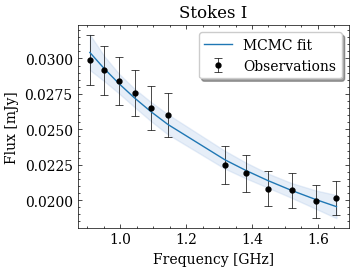

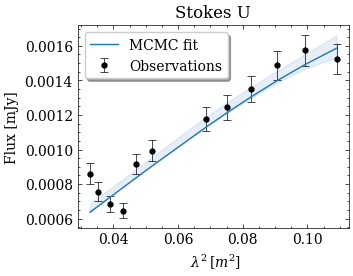

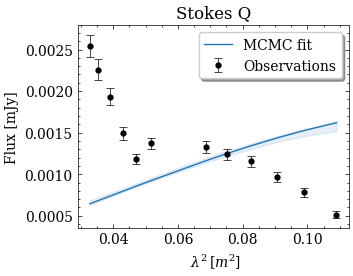

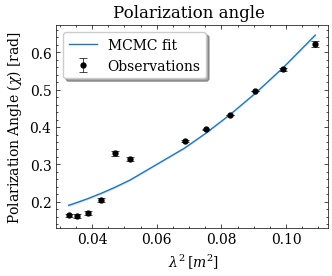

In [23]:
Stokes_I = median_I_0_StokesI*freq**(median_a_StokesI + median_b_StokesI*np.log10(freq))

plt.figure()
plt.errorbar(freq_m/1E9, I_table[:,0],yerr= I_table_err[:,0], color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5, label ='Observations')
# plt.plot(freq_m/1E6, I_table[:,0], 'k-.', alpha=0.5)
plt.plot(freq_m/1E9, median_I_0_StokesI*(freq_m/1E9)**(median_a_StokesI + median_b_StokesI*np.log10(freq_m/1E9)), color = palette(0), alpha = 1, label='MCMC fit')
plt.fill_between(freq_m/1E9,StokesI_16, StokesI_84, facecolor = palette(1), edgecolor = palette(1), alpha = 0.3)
plt.ylabel('Flux [mJy]')
plt.xlabel('Frequency [GHz]')
plt.title('Stokes I')
plt.legend(loc='best', frameon=True, shadow= True)
plt.savefig(fname='flux_stokesI_MCMC.pdf', dpi = 150)
plt.show()

plt.figure()
plt.errorbar(wave2, U_table[:,0],yerr= U_table_err[:,0], color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5, label ='Observations')
# plt.plot(freq_m/1E6, I_table[:,0], 'k-.', alpha=0.5)
plt.plot(wave2, Stokes_I*median_p0_StokesU*np.exp(-2*median_sigmaRM_StokesU*wave2**2)*np.sin(2*(median_chi0_StokesU+median_RM_StokesU*wave2)), color = palette(0), alpha = 1, label='MCMC fit')
plt.fill_between(wave2,StokesU_16, StokesU_84, facecolor = palette(1), edgecolor = palette(1), alpha = 0.3)
plt.ylabel('Flux [mJy]')
plt.xlabel(r' $\lambda^2 \, [m^2]$')
plt.title('Stokes U')
plt.legend(loc='best', frameon=True, shadow= True)
plt.savefig(fname='flux_stokesU_MCMC.pdf', dpi = 150)
plt.show()

plt.figure()
plt.errorbar(wave2, Q_table[:,0],yerr= Q_table_err[:,0], color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5, label ='Observations')
# plt.plot(freq_m/1E6, I_table[:,0], 'k-.', alpha=0.5)
plt.plot(wave2, Stokes_I*median_p0_StokesQ*np.exp(-2*median_sigmaRM_StokesQ*wave2**2)*np.cos(2*(median_chi0_StokesQ+median_RM_StokesQ*wave2)), color = palette(0), alpha = 1, label='MCMC fit')
plt.fill_between(wave2,StokesQ_16, StokesQ_84, facecolor = palette(1), edgecolor = palette(1), alpha = 0.3)
plt.ylabel('Flux [mJy]')
plt.xlabel(r' $\lambda^2 \, [m^2]$')
plt.title('Stokes Q')
plt.legend(loc='best', frameon=True, shadow= True)
plt.savefig(fname='flux_stokesQ_MCMC.pdf', dpi = 150)
plt.show()

plt.figure()
plt.errorbar(wave2, pol_ang ,yerr= np.abs(pol_ang_err), color = 'black', capsize= 3, capthick=0.5, fmt='.', markersize= 7, elinewidth = 0.5, label ='Observations')
# plt.plot(freq_m/1E6, I_table[:,0], 'k-.', alpha=0.5)
plt.plot(wave2, median_chi0_pol_ang + wave2**2*median_RM_pol_ang, color = palette(0), alpha = 1, label='MCMC fit')
plt.fill_between(wave2,pol_ang_16, pol_ang_84, facecolor = palette(1), edgecolor = palette(1), alpha = 0.3)
plt.ylabel(r'Polarization Angle $(\chi)$ [rad]')
plt.xlabel(r' $\lambda^2 \, [m^2]$')
plt.title('Polarization angle ')
plt.legend(loc='best', frameon=True, shadow= True)
plt.savefig(fname='pol_ang_MCMC.pdf', dpi = 150)
plt.show()
